# Simple PixelCNN

In [12]:
from SimplePCNN import SimplePCNN
import train
import ising
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy import integrate
import math

In [3]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [20]:
model = SimplePCNN(L=24, net_depth=3, net_width=16, kernel_size=5)
ising.J = -1. #Ferromag coupling in Ising model
trainer = train.Trainer(model, batch_size=50, learning_rate=0.001)

In [3]:
model.net.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masked_conv2d (MaskedConv2D) (None, 24, 24, 16)        416       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 24, 24, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 16)        272       
_________________________________________________________________
res_block (ResBlock)         (None, 24, 24, 16)        6688      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 24, 24, 1)         17        
Total params: 7,393
Trainable params: 7,393
Non-trainable params: 0
_________________________________________________________________


In [21]:
beta = 0.5
history = trainer.train_loop(iter=2500, beta=beta, anneal=True)
#Set anneal=False if you are running this cell second 
#time to train this model further

  0%|          | 0/2500 [00:00<?, ?it/s]WARNING:tensorflow:AutoGraph could not transform <bound method AutoregressiveModel.graph_sampler of <SimplePCNN.SimplePCNN object at 0x7f02d81749a0>> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no

In [22]:
trainer.model.save_weights('SimplePCNNwts/b_'+str(beta))

In [5]:
beta = 0.55
model.load_weights('SimplePCNNwts/b_'+str(beta))

In [6]:
sample = model.sample(200)

In [9]:
np.abs(np.mean(sample, axis=(1,2,3))).mean()

0.9081597222222223

In [3]:
beta = 0.55
history = trainer.train_loop(iter=2500, beta=beta, anneal=True)

  0%|          | 0/2500 [00:00<?, ?it/s]WARNING:tensorflow:AutoGraph could not transform <bound method AutoregressiveModel.graph_sampler of <SimplePCNN.SimplePCNN object at 0x7f9af51a9c10>> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no

In [4]:
trainer.model.save_weights('SimplePCNNwts/b_'+str(beta))

# Boltzmann PixelCNN

In [1]:
from BPnet import BPnet
import train
import ising
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy import integrate
import math

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [32]:
model = BPnet(L=32, net_depth=3, net_width=16, kernel_size=5)
model.load_weights('BPnetwts/b_0.475')
ising.J = -1. #Ferromag coupling in Ising model
trainer = train.Trainer(model, batch_size=50, learning_rate=0.005)

In [33]:
trainer.lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(0.005, 250, 0.8, True)

In [36]:
0.8**16

0.028147497671065624

In [37]:
beta = 0.475
history = trainer.train_loop(iter=4000, beta=beta, anneal=False)
#Set anneal=False if you are running this cell second 
#time to train this model further
trainer.model.save_weights("BPnetwts/b_"+str(beta))

100%|██████████| 4000/4000 [1:34:09<00:00,  1.41s/it]


# Free energy evaluation

In [1]:
from BPnet import BPnet
from SimplePCNN import SimplePCNN
import train
import ising
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy import integrate
import math

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
#The function to evaluate integral of
def func(theta, beta):
    t1 = math.cosh(2*beta)**2
    k = 1./(math.sinh(2*beta)**2)
    t2 = (1./k)*math.sqrt(1 + k**2 - 2*k*math.cos(2*theta))
    return math.log(t1 + t2)

def integrator(beta):
    result = np.empty(beta.shape, float)
    for i in range(beta.shape[0]):
        val = beta[i]
        integrand = lambda theta: func(theta, val)
        result[i] = integrate.quad(integrand, 0 , math.pi)[0]
    return result

### a) SimplePCNN

In [13]:
from SimplePCNN import SimplePCNN

In [10]:
model = SimplePCNN(L=36, net_depth=3, net_width=16, kernel_size=5)
betas = [0.35,0.4,0.425,0.45,
        0.475,0.5,0.55]
sample = []
log_prob = []
energy = []
free_energy = []

for beta in betas:
    model.load_weights('SimplePCNNwts/b_'+str(beta))
    sample.append(model.sample(200))
    log_prob.append(model.log_prob(sample[-1]))
    energy.append(ising.energy(sample[-1], pbc=True))
    free_energy.append(np.mean(((log_prob[-1]/beta)+energy[-1])/(model.L**2)))

In [11]:
beta = np.arange(0.3, 0.60001, 0.0125)
integral = integrator(beta)
F = -np.reciprocal(beta)*(math.log(2)/2 + integral*(1./(2*math.pi)))

In [12]:
betas = np.asarray(betas)
integral = integrator(betas)
F = -np.reciprocal(betas)*(math.log(2)/2 + integral*(1./(2*math.pi)))
free_energy_arr = np.asarray(free_energy)
error2 = (free_energy_arr-F)

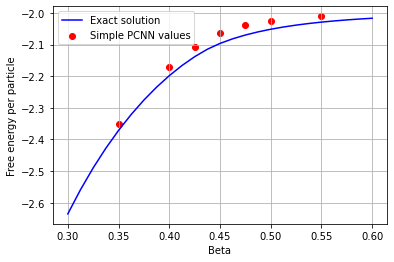

In [45]:
plt.plot(beta, F, color='blue', label='Exact solution')
plt.scatter(betas, free_energy, color='red', label='Simple PCNN values')
plt.xlabel('Beta')
plt.ylabel('Free energy per particle')
plt.grid()
plt.legend()
plt.savefig('SimplePCNN_free_ener.png')
plt.show()

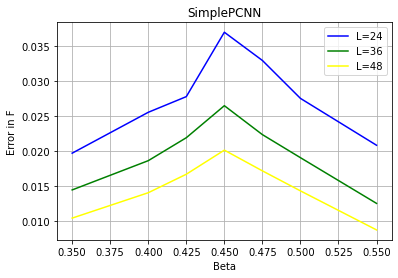

In [13]:
plt.plot(betas, error, color='blue', label='L=24')
plt.plot(betas, error2, color='green', label='L=36')
plt.plot(betas, error3, color='yellow', label='L=48')
plt.title('SimplePCNN')
plt.xlabel('Beta')
plt.ylabel('Error in F')
plt.grid()
plt.legend()
plt.savefig('F_DiffL_SimplePCNN.png')
plt.show()

### a) BPnet

In [76]:
model = BPnet(L=96, net_depth=3, net_width=16, kernel_size=5)
betas = [0.35,0.4,0.425,0.45,
        0.475,0.5,0.55]
samples = []
log_prob = []
energy = []
free_energy = []

for beta in betas:
    model.load_weights('BPnetwts/b_'+str(beta))
    samples.append(model.sample(200))
    log_prob.append(model.log_prob(samples[-1]))
    energy.append(ising.energy(samples[-1], pbc=True))
    free_energy.append(np.mean(((log_prob[-1]/beta)+energy[-1])/(model.L**2)))

In [77]:
mags2 = np.empty_like(betas)
Cv2 = np.empty_like(betas)

for i,sample in enumerate(samples):
    mags2[i] = np.mean(np.abs(np.mean(sample, axis=(1,2,3))))
    Cv2[i] = np.var(energy[i])

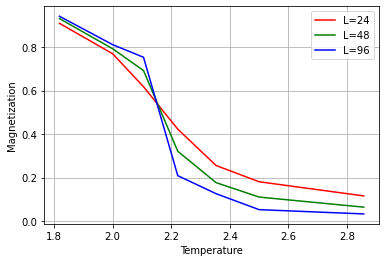

In [79]:
plt.plot(1./np.asarray(betas), mags1, label='L=24', color='red')
plt.plot(1./np.asarray(betas), mags3, label='L=48', color='green')
plt.plot(1./np.asarray(betas), mags2, label='L=96', color='blue')
plt.grid()
plt.xlabel('Temperature')
plt.ylabel('Magnetization')
plt.legend()
plt.savefig('BPnet_mags.png')
plt.show()

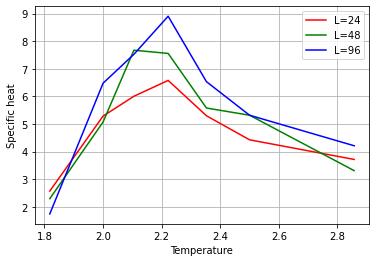

In [83]:
plt.plot(1./np.asarray(betas), Cv1/(24**2), label='L=24', color='red')
plt.plot(1./np.asarray(betas), Cv3/(48**2), label='L=48', color='green')
plt.plot(1./np.asarray(betas), Cv2/(96**2), label='L=96', color='blue')
plt.grid()
plt.xlabel('Temperature')
plt.ylabel('Specific heat')
plt.legend()
plt.savefig('BPnet_Cv.png')
plt.show()

In [21]:
beta = np.arange(0.3, 0.60001, 0.0125)
integral = integrator(beta)
F = -np.reciprocal(beta)*(math.log(2)/2 + integral*(1./(2*math.pi)))

In [22]:
betas = np.asarray(betas)
integral = integrator(betas)
F = -np.reciprocal(betas)*(math.log(2)/2 + integral*(1./(2*math.pi)))
free_energy_arr = np.asarray(free_energy)
error3 = (free_energy_arr-F)

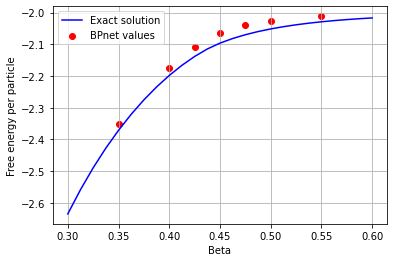

In [40]:
plt.plot(beta, F, color='blue', label='Exact solution')
plt.scatter(betas, free_energy, color='red', label='BPnet values')
plt.xlabel('Beta')
plt.ylabel('Free energy per particle')
plt.grid()
plt.legend()
plt.savefig('BPnet_free_ener.png')
plt.show()

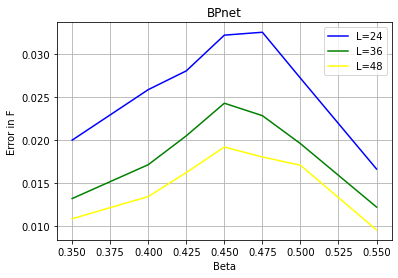

In [23]:
plt.plot(betas, error, color='blue', label='L=24')
plt.plot(betas, error2, color='green', label='L=36')
plt.plot(betas, error3, color='yellow', label='L=48')
plt.title('BPnet')
plt.xlabel('Beta')
plt.ylabel('Error in F')
plt.grid()
plt.legend()
plt.savefig('F_DiffL_BPnet.png')
plt.show()

### Sampling times of SimplePCNN and BPnet

In [37]:
from time import time
from scipy import stats

In [27]:
lens = np.arange(24, 121, 12, dtype=int)
times = np.empty_like(lens, float)

for i,L in enumerate(lens):
    model = SimplePCNN(L, net_depth=3, net_width=16, kernel_size=5)
    model.load_weights('SimplePCNNwts/b_0.45')
    t0 = time()
    model.sample(200)
    times[i] = time() - t0

In [29]:
lens = np.arange(24, 121, 12, dtype=int)
times2 = np.empty_like(lens, float)

for i,L in enumerate(lens):
    model = BPnet(L, net_depth=3, net_width=16, kernel_size=5)
    model.load_weights('BPnetwts/b_0.45')
    t0 = time()
    model.sample(200)
    times2[i] = time() - t0

In [28]:
times

array([   7.4296546 ,   30.48092818,   86.66682982,  202.32232666,
        405.40487814,  736.14312887, 1238.66184187, 1971.92775154,
       3001.33109379])

In [33]:
times2

array([  4.87966657,  13.26693058,  32.37037158,  91.84282613,
       131.94992805, 175.5694201 , 211.77747869, 249.13335085,
       315.22556186])

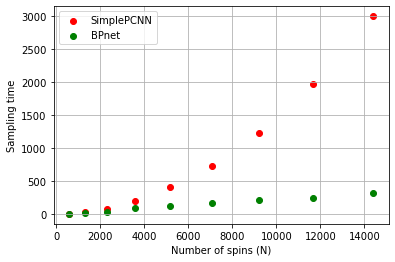

In [38]:
plt.scatter(lens**2, times, color='red', label='SimplePCNN')
plt.scatter(lens**2, times2, color='green', label="BPnet")
plt.xlabel('Number of spins (N)')
plt.ylabel('Sampling time')
plt.legend()
plt.grid()
plt.savefig('Sample_timings.png')
plt.show()

In [51]:
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures

In [55]:
X = np.expand_dims(lens**2, 1)
poly_ft = PolynomialFeatures(degree=2)
X2 = poly_ft.fit_transform(X)
Y = times
est = sm.OLS(Y, X2).fit()
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 4.678e+05
Date:                Wed, 12 May 2021   Prob (F-statistic):           2.64e-16
Time:                        18:27:04   Log-Likelihood:                -20.945
No. Observations:                   9   AIC:                             47.89
Df Residuals:                       6   BIC:                             48.48
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.7544      2.449      1.124      0.3

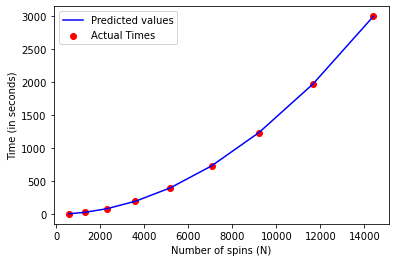

In [57]:
y_pred = est.predict(X2)
plt.scatter(lens**2, times, color='red', label='Actual Times')
plt.plot(lens**2, y_pred, color='blue', label='Predicted values')
plt.legend()
plt.xlabel('Number of spins (N)')
plt.ylabel('Time (in seconds)')
plt.show()

In [58]:
X = np.expand_dims(lens**2, 1)
poly_ft = PolynomialFeatures(degree=2)
X2 = poly_ft.fit_transform(X)
Y = times2
est = sm.OLS(Y, X2).fit()
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                     379.4
Date:                Wed, 12 May 2021   Prob (F-statistic):           4.83e-07
Time:                        18:50:10   Log-Likelihood:                -32.748
No. Observations:                   9   AIC:                             71.50
Df Residuals:                       6   BIC:                             72.09
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -19.6295      9.091     -2.159      0.0

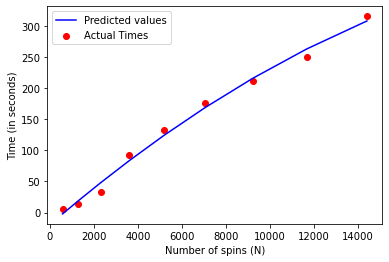

In [59]:
y_pred = est.predict(X2)
plt.scatter(lens**2, times2, color='red', label='Actual Times')
plt.plot(lens**2, y_pred, color='blue', label='Predicted values')
plt.legend()
plt.xlabel('Number of spins (N)')
plt.ylabel('Time (in seconds)')
plt.show()